# TDEM response of a conductive permeable casing 

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This example examines follows up on the FDEM surface to borehole logging example similar to that discussed in [Augustin et al. (1989)](https://doi.org/10.1190/1.1442581) and conducts a similar experiment in the time domain. This notebook was used to produce Figures 13 and 14  in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
# core python packages
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
import ipywidgets
import properties
import time 

# SimPEG and discretize
import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from SimPEG.Utils import Zero
from pymatsolver import Pardiso

# casing utilities
import casingSimulations as casingSim

%matplotlib inline

## Model Parameters

In [3]:
# create a simulation directory where results can be saved. 
simDir = 'TDEM_Augustin'  

We will two classes of examples
- permeable wells, one example is run for each $\mu_r$ in `casing_mur`. The conductivity of this well is `sigma_permeable_casing`
- conductive wells ($\mu_r$=1), one example is run for each $\sigma$ value in `sigma_casing`

To add model runs to the simulation, just add to the list

In [4]:
# permeabilities to model
casing_mur = [100]
sigma_casing = [1e8]

sigma_permeable_casing = 1e6

In [5]:
# background parameters
sigma_air = 1e-4
sigma_back = 1e-4
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter
casing_l = 2000

def get_model(mur, sigc):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_air = sigma_air,
        sigma_casing = sigc,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
        mur_casing = mur,
        src_a = np.r_[0., 0., 0.],
        src_b = np.r_[0., 0., 0.]
    )
 
    return model

## store the different models


In [6]:
model_names_permeable = ["casing_{}".format(mur) for mur in casing_mur]
model_names_conductive = ["casing_{:1.0e}".format(sig) for sig in sigma_casing]

# conductive, permeable models
model_dict_permeable = {
    key: get_model(mur, sigma_permeable_casing) for key, mur in zip(model_names_permeable, casing_mur)
}

model_dict_conductive = {
    key: get_model(1, sig) for key, sig in zip(model_names_conductive, sigma_casing)
}

model_names = model_names_conductive + model_names_permeable
model_dict = {}
model_dict.update(model_dict_permeable)
model_dict.update(model_dict_conductive)

In [7]:
model_dict["baseline"] = model_dict[model_names[0]].copy()
model_dict["baseline"].sigma_casing = model_dict["baseline"].sigma_back
model_names = ["baseline"] + model_names
model_names

['baseline', 'casing_1e+08', 'casing_100']

## Create a mesh

In [8]:
# parameters defining the core region of the mesh
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 23, 30  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
#         hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

In [9]:
mesh_generator = get_mesh(model_dict[model_names[0]])

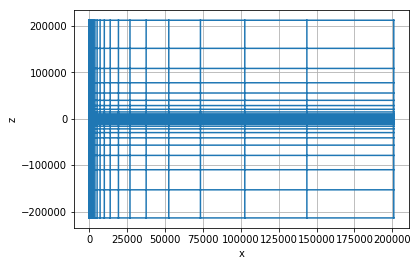

In [10]:
mesh_generator.mesh.plotGrid()

## Physical Properties

In [11]:
# Assign physical properties on the mesh
physprops = {
    name: casingSim.model.PhysicalProperties(mesh_generator, mod) 
    for name, mod in model_dict.items()
}

### conductivity

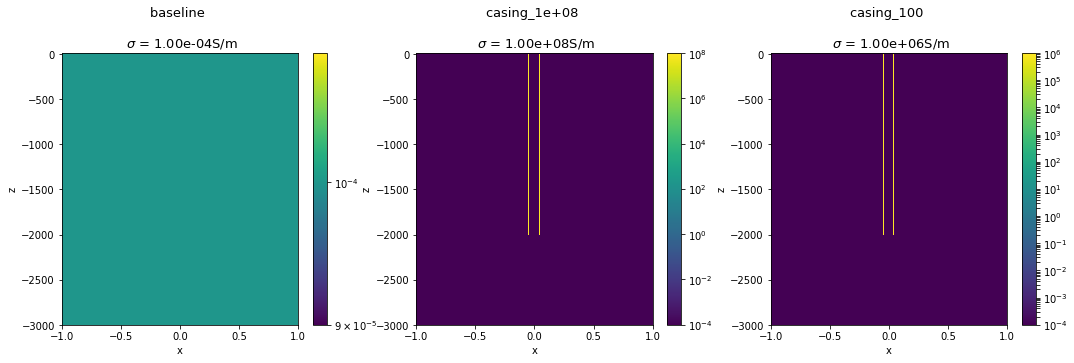

In [12]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physprops[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

### permeability

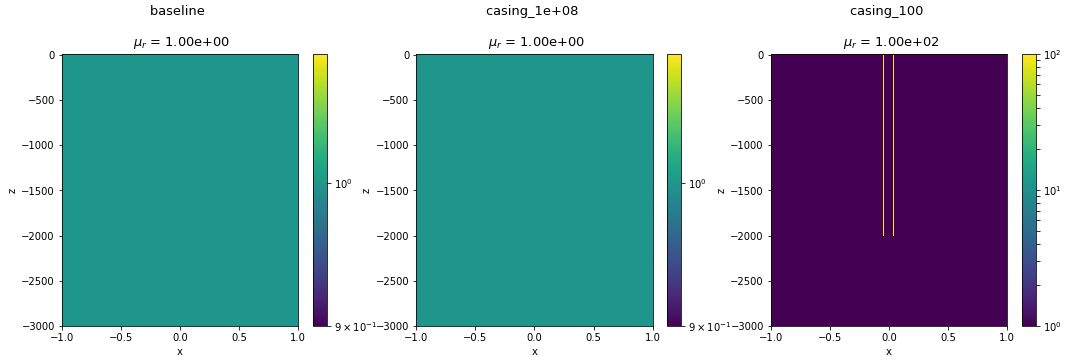

In [13]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physprops[title]
    pp.plot_mur(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\mu_r$ = {:1.2e}'.format(title, pp.modelParameters.mur_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Set up the time domain EM problem 

We run a time domain EM simulation with a large loop source (100m radius) and a b-field reciever down-hole at a depth of 500m. 

In [14]:
nsteps = 40
timeSteps = [
    (1e-6, nsteps), (5e-6, nsteps), (1e-5, nsteps), (5e-5, nsteps), (1e-4, nsteps), 
    (5e-4, nsteps), (1e-3, nsteps), (5e-3, nsteps), (1e-2, nsteps+60), (5e-2, nsteps)
]

for mod in model_dict.values():
    mod.timeSteps = timeSteps

In [15]:
times = np.hstack([0, model_dict[model_names[0]].timeSteps]).cumsum()
print("latest time: {:1.1f}s".format(times.max()))

latest time: 3.3s


In [16]:
rx = TDEM.Rx.Point_b(locs=np.array([0., 0., -500.]), times=times, orientation="z")

In [17]:
src_list = [
    TDEM.Src.CircularLoop(
        [rx], 
        loc=np.r_[0., 0., 0.], orientation="z", radius=100,
    )
]

## Set up the simulation 

In [18]:
wires = physprops[model_names[0]].wires # keeps track of which model parameters are sigma and which are mu

prob = TDEM.Problem3D_b(
    mesh=mesh_generator.mesh, sigmaMap=wires.sigma, timeSteps=timeSteps,
    Solver=Pardiso
)

In [19]:
survey = TDEM.Survey(srcList=src_list)
prob.pair(survey)

## Run the simulation

- for each permeability model we run the simulation for 2 conductivity models (casing = $10^6$S/m and $10^{-4}$S/m
- each simulation takes 15s-20s on my machine: the next cell takes ~ 4min to run

In [20]:
%%time
fields_dict = {}

for key in model_names:
    t = time.time()
    pp = physprops[key]    
    prob.mu = pp.mu
    
    print('--- Running {} ---'.format(key))
    fields_dict[key] = prob.fields(pp.model)
    print(" ... done. Elapsed time {}\n".format(time.time() - t))

--- Running baseline ---
 ... done. Elapsed time 47.9476950169

--- Running casing_1e+08 ---
 ... done. Elapsed time 31.0578429699

--- Running casing_100 ---
 ... done. Elapsed time 29.3830161095

CPU times: user 2min 52s, sys: 13.5 s, total: 3min 5s
Wall time: 1min 48s


## Compute data at the receiver 
- bz data 500m below the surface, coaxial with casing

In [21]:
for src in src_list:
    src.rxList = [rx]

In [22]:
%%time

data = {}

for key in model_names:
    t = time.time()
    pp = physprops[key]
    prob.mu = pp.mu
    
    print('--- Running {} ---'.format(key))
    data[key] = survey.dpred(pp.model, f=fields_dict[key])
    print(" ... done. Elapsed time {} \n".format(time.time() - t))

--- Running baseline ---
 ... done. Elapsed time 5.29345202446 

--- Running casing_1e+08 ---
 ... done. Elapsed time 4.97948813438 

--- Running casing_100 ---
 ... done. Elapsed time 4.96275997162 

CPU times: user 12.2 s, sys: 2.81 s, total: 15.1 s
Wall time: 15.2 s


## Plot Data

In [23]:
def plot_data(ax=None, scale='loglog', view=None, models=None):
    """
    Plot the time domain EM data.
    - scale can be and of ["loglog", "semilogx", "semilogy", "plot"]
    - view can be ["nsf", "secondary-wholespace", "secondary-conductive"] or None (None plots the data)
    - models is a list of model names to plot
    """
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, dpi=400)
        ax = [ax]
    
    plot_models = model_names[1:]
    
    if models is not None: 
        if isinstance(models, list):
            plot_models = models
        else:
            if models.lower() == "permeable":
                plot_models = model_names_permeable
            elif models.lower() == "conductive":
                plot_models = model_names_conductive
        

    for i, key in enumerate(plot_models):
        mod = model_dict[key]
        label = "$\sigma = {:1.0e}$, $\mu_r$ = {}".format(mod.sigma_casing, mod.mur_casing)
            
        # get property to plot
        if view is not None: 
            if view.lower() in ["secondary-wholespace", "nsf"]:
                plotme = data[key] - data['baseline']
                if view.lower() == "nsf":
                    plotme = plotme / data['baseline'][0]                
            elif subtract.lower() == "secondary-conductive": 
                plotme = data[key] - data[model_names[1]]
        else:
            plotme = data[key]
         
        # conductive casing
        getattr(ax[0], scale)(rx.times, plotme, "-", color="C{}".format(i), label=label)
        if scale.lower() not in ["semilogx", "plot"]:
            getattr(ax[0], scale)(rx.times, -plotme, "--", color="C{}".format(i))


    # background
    if view is None:
        getattr(ax[0], scale)(
            rx.times, data['baseline'], "-", color='k', label="background"
        )
        if scale.lower()  not in ["semilogx", "plot"]:
            getattr(ax[0], scale)(
                rx.times, -data['baseline'], "--", color='k'
            )

    [a.set_xlabel("time (s)") for a in ax]
    [a.set_ylabel("magnetic field $b_z$ (T)") for a in ax]

    [a.grid(which='both', alpha=0.4) for a in ax]
    [a.legend() for a in ax]

    plt.tight_layout()
    
    return ax


## Figure 13: Normalized secondary field

Text(112.792,0.5,u'NSF')

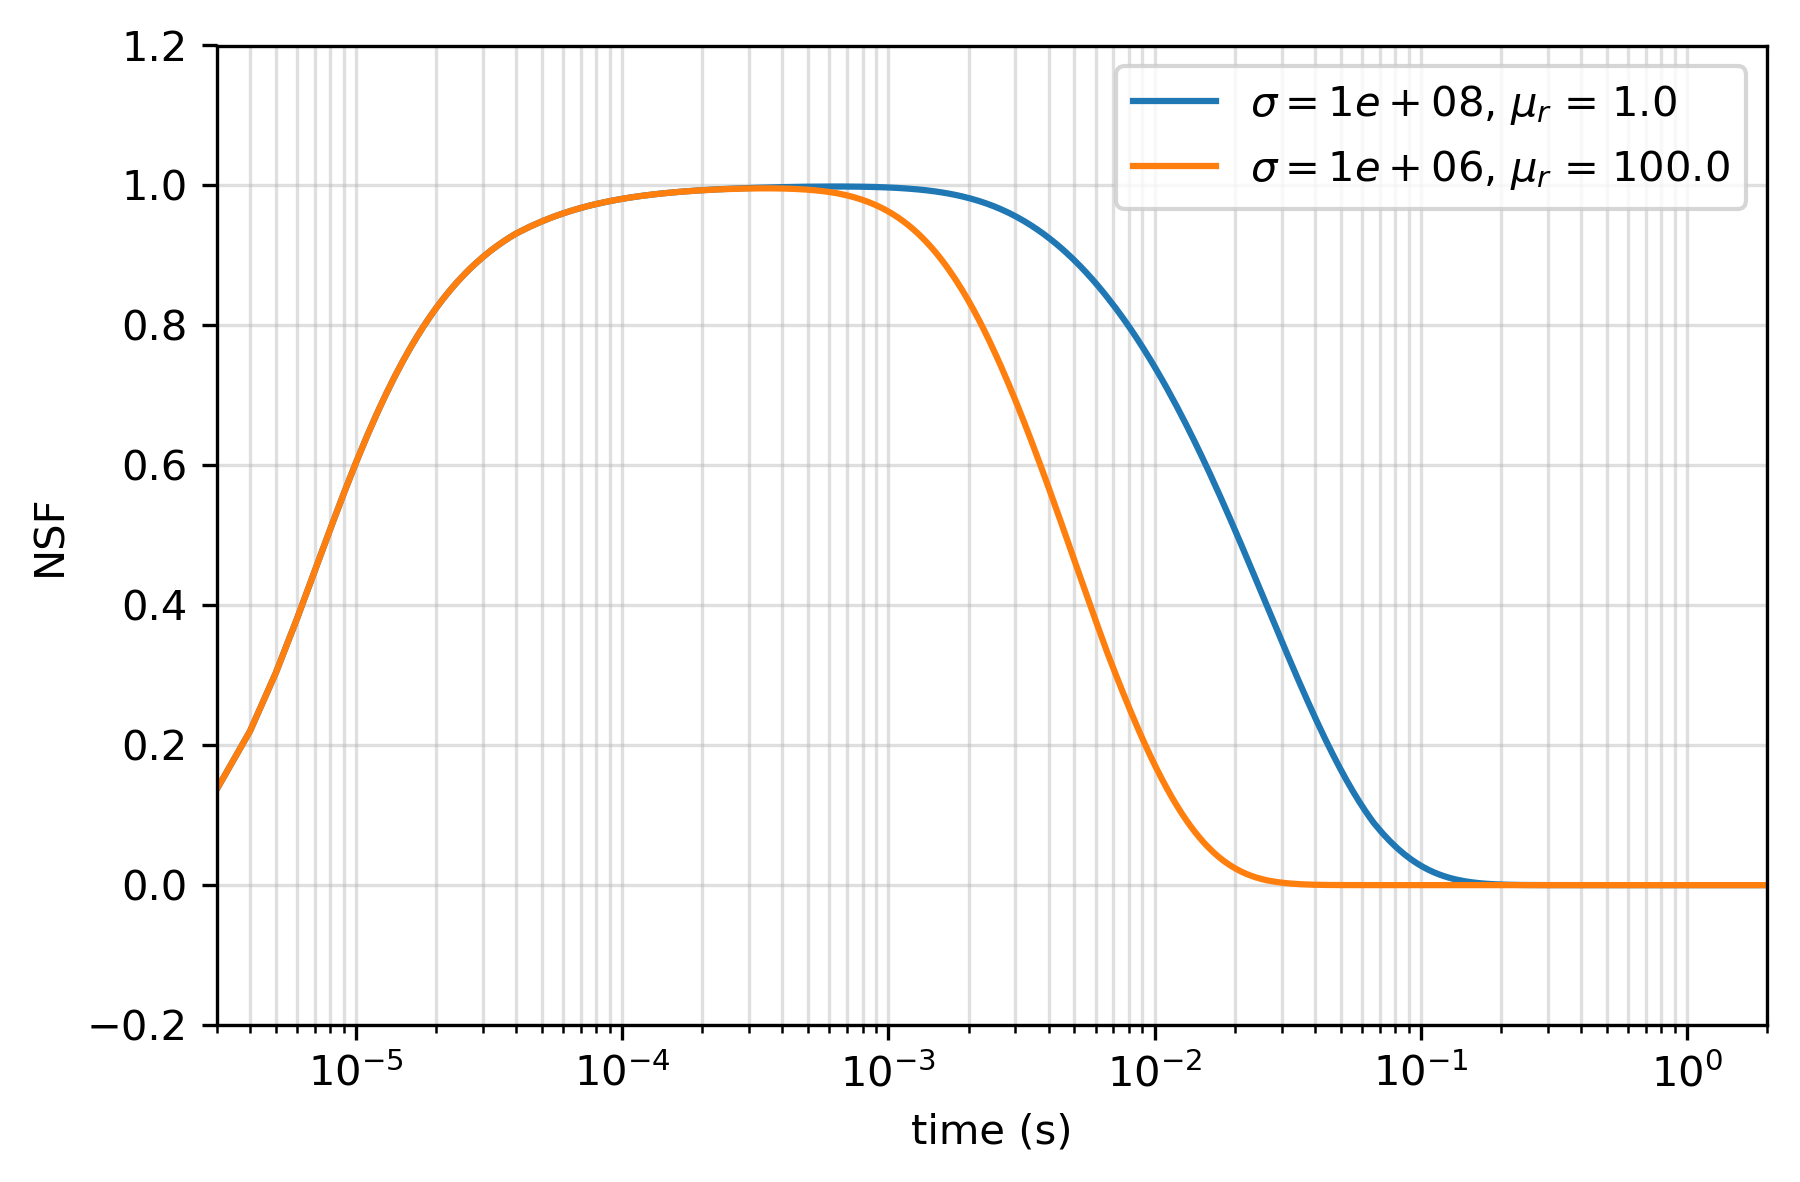

In [24]:
fig, ax = plt.subplots(1, 1, dpi=300)
ax = plot_data(scale="semilogx", view="NSF", models=["casing_1e+08", "casing_100"], ax=[ax])
ax[0].set_xlim([3e-6, 2])
ax[0].set_ylim([-0.2, 1.2])
ax[0].set_ylabel("NSF")

In [25]:
# fig.savefig("tdemNSF")

In [26]:
sim_dict = {}
for key in model_names:
    sim = casingSim.run.SimulationTDEM(
        directory=simDir, 
        meshGenerator=mesh_generator,
        modelParameters=model_dict[key],
        formulation=prob._fieldType[0],
    )
    sim._prob = prob
    sim._survey = survey
    sim_dict[key] = sim

# Build a widget

## View the fields and fluxes

This is a widget for interrogating the results. 
- `max_r`: maximum radial extent of the plot (m)
- `min_depth`: minimum depth (m)
- `max_depth`: maximum depth (m)
- `clim_min`: minimum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `clim_max`: maximum colorbar limit. If `0`, then the colorbar limits are the plotting defaults
- `model_key`: model which we are viewing
- `view`: field or physical property that is plotted
- `prim_sec`: `primary` plots the background, `secondary` subtracts the `primary` response from the current value (note that if you select `background` and `secondary` the value will be zero and an error thrown
- `time_ind`: index of the time-step we are plotting
- `show_mesh`: if checked, the mesh will be plotted on the right hand half of the plot
- `use_aspect`: if checked, the aspect ratio of the axes is set to 1 (eg. no vertical or horizontal exxageration) 
- `casing_outline`: draws the outline of the casing

In [27]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, 
    primary_key='baseline'
)

In [28]:
viewer.widget_cross_section(defaults={'view': 'b', "time_ind": 1})

Widget Javascript not detected.  It may not be installed or enabled properly.


<function ipywidgets.widgets.interaction.<lambda>>

## Figure 14

In [29]:
from matplotlib import rcParams
rcParams['font.size'] = 16

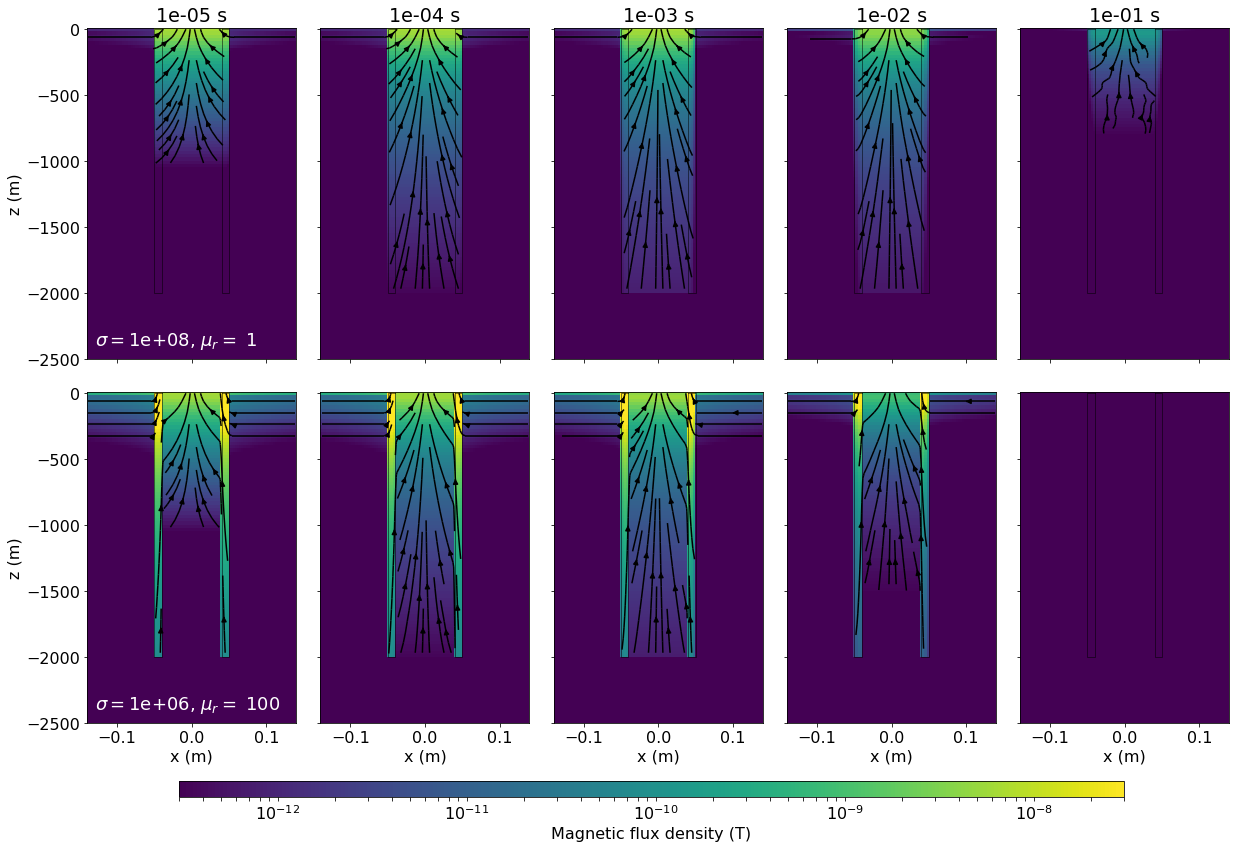

In [30]:
fig, ax = plt.subplots(2, 5, figsize=(3.5*5, 5.5*2))
fig.subplots_adjust(bottom=0.8)

clim = [3e-13, 3e-8]
max_depth = 2500
top = 10
max_r = 0.14
view='b'
# primsec="secondary"

tinds = [10, 52, 128, 207, 287]

for i, tind in enumerate(tinds):
    for j, m in enumerate(["casing_1e+08", "casing_100"]):
        a = ax[j, i]
        out = viewer.plot_cross_section(
            ax=a, clim=clim, xlim=max_r * np.r_[-1., 1.],
            zlim = np.r_[-max_depth, top],
            view=view, model_key=m, 
            prim_sec="secondary", 
            casing_outline=True,
            time_ind=tind, 
            show_cb=False
        )
        
        
        if j == 0:
            a.set_title("{:1.0e} s".format(times[tind]))
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            
            
        else:
            a.set_title("")
            a.set_xlabel("x (m)")
    
        if i > 0:
            a.set_yticklabels(['']*len(a.get_yticklabels()))
            a.set_ylabel('')
        else:
            a.set_ylabel('z (m)')
            mod = model_dict[m]
            a.text(
                -0.13, -2400, "$\sigma = ${:1.0e}, $\mu_r = $ {:1.0f}".format(mod.sigma_casing, mod.mur_casing), 
                color="w", fontsize=18
            )


plt.tight_layout()


cbar_ax = fig.add_axes([0.15, -0.02, 0.75, 0.02])
cb = fig.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Magnetic flux density (T)')


In [31]:
# fig.savefig("btdem", dpi=300, bbox_inches="tight")